In [63]:
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Lambda, Activation, Input
import tensorflow.keras.backend as K
import sklearn.preprocessing
import gc
import psutil
import collections
import matplotlib.pyplot as plt
import seaborn as sns

<h2> Generate Training Data for Network </h2>

In [57]:
intmatrix = np.load("./data/movie-matrix.npz")['data']
mean = np.sum(intmatrix, axis=1)/(intmatrix!=0).sum(axis=1)
zmask = intmatrix==0
intmatrix = intmatrix-mean.reshape(-1,1)
intmatrix[zmask]=0

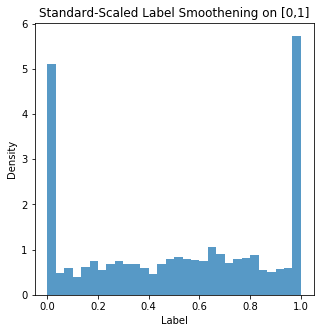

((89938, 1682), (89938, 943), (89938,))

In [67]:
Usr = np.repeat(intmatrix, np.sum(intmatrix!=0, axis=1), axis=0)
Itm = np.zeros((np.sum(intmatrix!=0),intmatrix.shape[0]), dtype=np.float64)
pos = 0
for i in range(intmatrix.shape[0]):
    newval = intmatrix[:,intmatrix[i]!=0].T
    Itm[pos:pos+newval.shape[0],:] = newval
    pos+=newval.shape[0]
Y = (sklearn.preprocessing.StandardScaler().fit_transform(intmatrix[intmatrix!=0].reshape(-1,1))[:,0]+1)/2
Y[Y>1], Y[Y<0]= 1, 0
plt.figure(figsize=(5,5))
plt.hist(Y, density=True, alpha=0.75, bins=30)
plt.title("Standard-Scaled Label Smoothening on [0,1]")
plt.xlabel("Label")
plt.ylabel("Density")
plt.show()
Usr.shape, Itm.shape, Y.shape

In [99]:
np.random.seed(1)
testindex = np.random.choice(Usr.shape[0], np.int(0.2*Usr.shape[0]), replace=False)
trainindex = np.array(list(set(np.arange(Usr.shape[0]))-set(testindex)))
trainU, testU = Usr[trainindex], Usr[testindex]
trainI, testI = Itm[trainindex], Itm[testindex]
trainY, testY = Y[trainindex], Y[testindex]
trainU.shape, trainI.shape, trainY.shape

((71951, 1682), (71951, 943), (71951,))

<h2>Design Siamese Network</h2>

In [76]:
def smoothened_entropy(ytrue, ypred):
    return -tf.math.reduce_sum(tf.math.log(1-tf.math.abs(ypred-ytrue)))

In [112]:
K.clear_session()
userinput = Input(Usr.shape[1])
iteminput = Input(Itm.shape[1])
#Use fixed 256-length internal vector embeddings
latentdim = 256
Du = Dense(latentdim, activation="relu")(userinput)
Di = Dense(latentdim, activation="relu")(iteminput)
L1dist = Lambda(lambda tensors: tensors[0]-tensors[1])
emb = L1dist([Du, Di])
output = Dense(1, activation="sigmoid")(emb)
model = Model(inputs=[userinput, iteminput], outputs=output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=smoothened_entropy)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1682)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 943)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          430848      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          241664      input_2[0][0]                    
______________________________________________________________________________________________

<h2>Train Siamese Network</h2>

In [113]:
def lrscheduler(epoch, init=1e-3):
    return init*0.95**(epoch-5) if epoch>5 else init

In [114]:
lr = tf.keras.callbacks.LearningRateScheduler(lrscheduler, verbose=0)
chk = tf.keras.callbacks.ModelCheckpoint("./data/siam.h5", monitor="val_loss", save_weights_only=True, 
                                         save_best_only=True, save_freq="epoch")
hist = model.fit([trainU, trainI], trainY, validation_data=([testU, testI], testY), batch_size=512, 
                callbacks=[chk, lr], epochs=20)

Train on 71951 samples, validate on 17987 samples
Epoch 1/20
71951/71951 [==============================] - 3s 42us/sample - loss: -0.1614 - val_loss: -0.1737
Epoch 2/20
71951/71951 [==============================] - 2s 24us/sample - loss: -0.1727 - val_loss: -0.1745
Epoch 3/20
71951/71951 [==============================] - 2s 23us/sample - loss: -0.1731 - val_loss: -0.1747
Epoch 4/20
71951/71951 [==============================] - 2s 23us/sample - loss: -0.1732 - val_loss: -0.1748
Epoch 5/20
71951/71951 [==============================] - 2s 23us/sample - loss: -0.1733 - val_loss: -0.1749
Epoch 6/20
71951/71951 [==============================] - 2s 22us/sample - loss: -0.1733 - val_loss: -0.1749
Epoch 7/20
71951/71951 [==============================] - 2s 23us/sample - loss: -0.1733 - val_loss: -0.1749
Epoch 8/20
71951/71951 [==============================] - 2s 24us/sample - loss: -0.1733 - val_loss: -0.1749
Epoch 9/20
71951/71951 [==============================] - 2s 23us/sample - los